#### Data class


In [1]:
import random

class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else:
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)

#### Load data

In [2]:
import json

fileName = './data/Books_small_10000.json'

reviews = []
with open(fileName) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))
        
reviews[4].text

'It was a decent read.. typical story line. Nothing unsavory as so many are. Just a slice of life, plausible.'

#### Data Prep

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(train)
test_container = ReviewContainer(test)

In [4]:
train_container.evenly_distribute()
train_x = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

train_y.count(Sentiment.POSITIVE)
train_y.count(Sentiment.NEGATIVE)

436

#### Bag of words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)

test_x_vectors = vectorizer.transform(test_x)

print(train_x[0])
print(train_x_vectors[0].toarray())

My friend's two and a half year old enjoyed it but it didn't capture her attention too long. The canine she liked best of course was the one that howled but maybe it was my acting that enhanced her enjoyment. Fortunately for the neighbors, my dogs did not join me in the musical presentation. By all means, get this for your child and get ready to perform!
[[0. 0. 0. ... 0. 0. 0.]]


#### Classification

###### Linear SVM

In [6]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(train_x_vectors, train_y)
clf_svm.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

###### Random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500)
clf_rf.fit(train_x_vectors, train_y)
clf_rf.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

###### Naive Bayes

In [8]:
from sklearn.naive_bayes import BernoulliNB

clf_gnb = BernoulliNB()
clf_gnb.fit(train_x_vectors, train_y)
clf_gnb.predict(test_x_vectors[0])

array(['POSITIVE'], dtype='<U8')

#### Evaluation

In [9]:
# MEAN accuracy
#print(clf_svm.score(test_x_vectors, test_y))
#print(clf_rf.score(test_x_vectors, test_y))
#print(clf_gnb.score(test_x_vectors, test_y))

In [10]:
# F1 scores
#from sklearn.metrics import f1_score

#f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])
#f1_score(test_y, clf_dt.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])
#f1_score(test_y, clf_lr.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])

In [29]:
test_set = ['bad book', 'bad book, waste of time to read book', 'bad book, dont buy and its a waste of money', "good book, do buy it and all of the contents of this book is very inspirational"]
new_test = vectorizer.transform(test_set)

clf_gnb.predict(new_test)

array(['POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE'], dtype='<U8')

# Tuning the model with Grid search

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,6,16,32)}

tunned_svm = svm.SVC()
clf = GridSearchCV(tunned_svm, parameters, cv=5)
clf.fit(train_x_vectors, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 6, 16, 32), 'kernel': ('linear', 'rbf')})

In [13]:
print(clf.score(test_x_vectors, test_y))

0.8197115384615384


In [14]:
#f1_score(test_y, clf.predict(test_x_vectors), average=None, labels=[Sentiment.POSITIVE, Sentiment.NEGATIVE])

#### Saving model

In [15]:
#import pickle

In [16]:
#with open('./sentiment_classifier.pkl', 'wb') as f:
 #   pickle.dump(clf, f)

#### load model

In [17]:
#with open('./sentiment_classifier.pkl', 'rb') as f:
 #   loaded_clf = pickle.load(f)

In [18]:
#loaded_clf.predict(test_x_vectors[0])

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

#### SVM Confusion matrix

<AxesSubplot:>

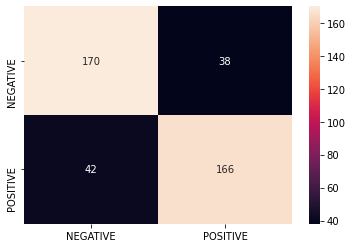

In [20]:
y_pred = clf_svm.predict(test_x_vectors)

labels = [Sentiment.NEGATIVE, Sentiment.POSITIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

#### Random Forest confusion matrix

<AxesSubplot:>

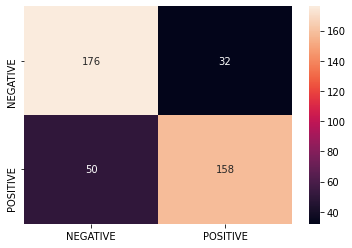

In [21]:
y_pred = clf_rf.predict(test_x_vectors)

labels = [Sentiment.NEGATIVE, Sentiment.POSITIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

#### Naive Bayes confusion matrix

<AxesSubplot:>

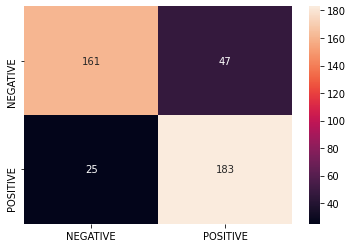

In [22]:
y_pred = clf_gnb.predict(test_x_vectors)

labels = [Sentiment.NEGATIVE, Sentiment.POSITIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')